In [3]:
import seaborn as sns
sns.set()
import altair as alt

In [1524]:
import numpy as np
import pandas as pd
from numpy import random as rd
import tensorflow as tf
from tensorflow import keras

from sklearn.compose import ColumnTransformer

# SQLite and Data Preprocessing 


### SQL to Dataframe  

In [619]:

import sqlalchemy
from sqlalchemy import create_engine

from sqlalchemy import inspect


In [620]:
engine = create_engine("sqlite:///microstructures.sqlite")

In [621]:
MD = sqlalchemy.MetaData(bind = engine)

In [622]:
conn = engine.connect()

In [628]:
inspector = inspect(engine)

In [2]:
'''
for table_name in inspector.get_table_names():
   for column in inspector.get_columns(table_name):
       print("Table: %s" % table_name , " Column: %s" % column['name'])
'''        

'\nfor table_name in inspector.get_table_names():\n   for column in inspector.get_columns(table_name):\n       print("Table: %s" % table_name , " Column: %s" % column[\'name\'])\n'

In [630]:
#### JOINS the micrograph table to the sample data table


micrographs = """

SELECT *
FROM micrograph JOIN sample ON sample_id = sample_key


"""

In [743]:
###  This is the main dataframe
micrographs_df =pd.read_sql_query(micrographs, conn)

In [751]:

micrographs_df

,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent,sample_id,label,anneal_time,anneal_time_unit,anneal_temperature,anneal_temp_unit,cool_method
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42,2,pearlite,42,ET Gyro,NaN,None,NaN,None,None
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18,2,spheroidite,18,AC1 800C 85H WQ,85.0,H,800.0,C,WQ
2,4,micrograph4.tif,10.0,um,129,None,SE,35,2,pearlite+spheroidite,35,AC1 970C 90M FC,90.0,M,970.0,C,FC
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10,2,pearlite,10,AC1 750C 5M WQ,5.0,M,750.0,C,WQ
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29,2,spheroidite,29,AC1 970C 90M AR,90.0,M,970.0,C,AR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,1723,micrograph1723.tif,10.0,um,103,1964X,BSE,41,2,martensite,41,AC1 IS1010H 35X etched,NaN,None,NaN,None,None
799,1726,micrograph1726.tif,5.0,um,90,3437X,SE,34,2,spheroidite+widmanstatten,34,AC1 970 5M FC,5.0,M,970.0,C,FC
800,1730,micrograph1730.png,10.0,um,103,1964X,SE,40,2,spheroidite,40,AC1 970C 90M Q,90.0,M,970.0,C,Q
801,1731,micrograph1731.tif,1.0,um,129,24551X,SE,47,2,pearlite,47,SIS_XL.TIF,NaN,None,NaN,None,None


Above we see that the main features are:\
&emsp; magnification\
&emsp; primary_microconstituent\
&emsp; anneal_time (along with anneal_time_unit)\
&emsp; anneal_temp\
&emsp; cool_method
    

In [735]:
### dataframe with only annealed samples

micro_anneal_df = micrographs_df.dropna()
micro_anneal_df.shape

(527, 17)

### Custom Transformers for Data Preprocessing

The anneal time is in minutes and hours, and we will convert evething to minutes.\
The anneal temperature is Celsius which is bad for scaling so we will convert to Kelvin

In [638]:
from sklearn.base import BaseEstimator,TransformerMixin

In [640]:
class ToKelvin(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
        return self
        
    def transform(self, X, y = None):
        return X + 273.15
    

In [745]:
class ToMinute(BaseEstimator, TransformerMixin):
    
    def __init__(self, dataseries):
        self.dataseries = dataseries
        self.multi = self.dataseries.apply(self._M_to_K)
        
    def _M_to_K(self, char):
        if char == 'H':
            return 60
        if char == 'M':
            return 1
        else: 
            return 0
        
    def fit(self,X,y = None):
        return self
    
    
    def transform(self, X, y = None):
        
        return X*self.multi
    

In [748]:
# testing ToMinute by itself

minutes = ToMinute(micrographs_df['anneal_time_unit'])
anneal_time_minutes = minutes.transform(micrographs_df['anneal_time'])


0         NaN
1      5100.0
2        90.0
3         5.0
4        90.0
        ...  
798       NaN
799       5.0
800      90.0
801       NaN
802       5.0
Length: 803, dtype: float64

In [755]:
micrographs_minutes = micrographs_df.copy()
micrographs_minutes.loc[:,'anneal_time'] = anneal_time_minutes

In [758]:
micro_M_K = micrographs_minutes
micro_M_K.loc[:, 'anneal_temperature'] += 273.15


### This is our main data frame (before OHE)

In [761]:
###  This is our main data frame

main_micrographs_df = micro_M_K[['path',
                                 'magnification',
                                 'primary_microconstituent',
                                 'anneal_time',
                                 'anneal_temperature',
                                 'cool_method'
                                ]]

In [892]:
main_micrographs_df.head()

,path,magnification,primary_microconstituent,anneal_time,anneal_temperature,cool_method
0,micrograph1.tif,4910x,pearlite,NaN,NaN,None
1,micrograph2.tif,1964X,spheroidite,5100.0,1073.15,WQ
2,micrograph4.tif,None,pearlite+spheroidite,90.0,1243.15,FC
3,micrograph5.tif,4910X,pearlite,5.0,1023.15,WQ
4,micrograph6.tif,1178X,spheroidite,90.0,1243.15,AR


### One Hot Encoding

we use get_dummies from pandas since we will be using flow_from_dataframe

In [775]:
ohe_main_micrographs =pd.get_dummies(main_micrographs_df, columns = [
                                 'magnification',
                                 'primary_microconstituent',
                                 'anneal_time',
                                 'anneal_temperature',
                                 'cool_method'
                                ], dummy_na = True)

In [1044]:

new_df = main_micrographs_df[['path','primary_microconstituent','anneal_time','anneal_temperature','cool_method']]
#new_df = new_df.astype('string')
new_df.dtypes
#new_df.fillna('Nothing', inplace = True)
#new_df['primary_microconstituent'].values.unique()
#new_df['primary_microconstituent'].isna().sum()

path                         object
primary_microconstituent     object
anneal_time                 float64
anneal_temperature          float64
cool_method                  object
dtype: object

In [1078]:
new_df['anneal_temperature']=new_df['anneal_temperature'].astype('string')

C:\Users\Owner\AppData\Local\Temp\ipykernel_22316\3460716308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['anneal_temperature']=new_df['anneal_temperature'].astype('string')


In [1079]:
new_df.dtypes

path                        object
primary_microconstituent    object
anneal_time                 string
anneal_temperature          string
cool_method                 object
dtype: object

In [1240]:
new_df

,path,primary_microconstituent,anneal_time,anneal_temperature,cool_method,time_temp
0,micrograph1.tif,pearlite,Not Annealed,Not Annealed,None,"(Not Annealed, Not Annealed)"
1,micrograph2.tif,spheroidite,5100.0,1073.15,WQ,"(5100.0, 1073.15)"
2,micrograph4.tif,pearlite+spheroidite,90.0,1243.15,FC,"(90.0, 1243.15)"
3,micrograph5.tif,pearlite,5.0,1023.15,WQ,"(5.0, 1023.15)"
4,micrograph6.tif,spheroidite,90.0,1243.15,AR,"(90.0, 1243.15)"
...,...,...,...,...,...,...
798,micrograph1723.tif,martensite,Not Annealed,Not Annealed,None,"(Not Annealed, Not Annealed)"
799,micrograph1726.tif,spheroidite+widmanstatten,5.0,1243.15,FC,"(5.0, 1243.15)"
800,micrograph1730.png,spheroidite,90.0,1243.15,Q,"(90.0, 1243.15)"
801,micrograph1731.tif,pearlite,Not Annealed,Not Annealed,None,"(Not Annealed, Not Annealed)"


In [1304]:
new_df['time_temp'] = new_df['anneal_time'] + ' , ' +new_df['anneal_temperature']

In [1303]:

new_df['time_temp_string'] =new_df['time_temp'][:][0] + ',' + new_df['time_temp'][:][1] 

TypeError: can only concatenate tuple (not "str") to tuple

In [1305]:
new_df['time_temp']

0      Not Annealed , Not Annealed
1                 5100.0 , 1073.15
2                   90.0 , 1243.15
3                    5.0 , 1023.15
4                   90.0 , 1243.15
                  ...             
798    Not Annealed , Not Annealed
799                  5.0 , 1243.15
800                 90.0 , 1243.15
801    Not Annealed , Not Annealed
802                   5.0 , 973.15
Name: time_temp, Length: 803, dtype: string

In [1306]:
time_temp = list(set(new_df['time_temp'].tolist()))

In [1406]:
new_df['anneal_temperature'].value_counts()

1243.15         344
Not Annealed    205
1073.15         149
1173.15          60
1373.15          16
1273.15          14
973.15           11
1023.15           4
Name: anneal_temperature, dtype: Int64

In [1022]:
#pm =new_df['primary_microconstituent']=='spheroidite+widmanstatten'

new_df['primary_microconstituent']=new_df['primary_microconstituent'].apply(lambda x:x.split("+"))
#new_df.loc[pm,'primary_microconstituent'] = ['spheroidite','widmanstatten']
new_df['primary_microconstituent']

C:\Users\Owner\AppData\Local\Temp\ipykernel_22316\781710086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['primary_microconstituent']=new_df['primary_microconstituent'].apply(lambda x:x.split("+"))


0                        [pearlite]
1                     [spheroidite]
2           [pearlite, spheroidite]
3                        [pearlite]
4                     [spheroidite]
                   ...             
798                    [martensite]
799    [spheroidite, widmanstatten]
800                   [spheroidite]
801                      [pearlite]
802                      [pearlite]
Name: primary_microconstituent, Length: 803, dtype: object

In [1374]:
temperature_classes = list(set(new_df['anneal_temperature'].values.tolist()))


In [1412]:
t_class_weights = [344/14,1,344/205,344/4,344/60,344/16,344/11,344/149]
t_class_weights

In [1375]:
temperature_classes

['1273.15',
 '1243.15',
 'Not Annealed',
 '1023.15',
 '1173.15',
 '1373.15',
 '973.15',
 '1073.15']

In [1023]:
new_list = [element for list_ in new_df['primary_microconstituent'] for element in list_]
set(new_list)

{'martensite', 'network', 'pearlite', 'spheroidite', 'widmanstatten'}

In [1083]:
new_class = list(set(new_list))
new_class

['widmanstatten', 'spheroidite', 'martensite', 'network', 'pearlite']

In [794]:
ohe_main_micrographs


,path,magnification_102x,magnification_11785x,magnification_1178X,magnification_118x,magnification_14731x,magnification_1473X,magnification_147x,magnification_19641X,magnification_19641x,...,anneal_temperature_1373.15,anneal_temperature_nan,cool_method_650-1H,cool_method_AR,cool_method_FC,cool_method_Q,cool_method_WC,cool_method_WQ,cool_method_WQ-2C,cool_method_nan
0,micrograph1.tif,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,micrograph2.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,micrograph4.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,micrograph5.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,micrograph6.tif,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,micrograph1723.tif,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
799,micrograph1726.tif,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
800,micrograph1730.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
801,micrograph1731.tif,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [1127]:
y_cols =list (ohe_main_micrographs.columns[42:])

P_M_cols = list (ohe_main_micrographs.columns[42:50])
Temp_cols = list (ohe_main_micrographs.columns[59:67])
cool_cols =list (ohe_main_micrographs.columns[67:75])
cool_cols



['cool_method_650-1H',
 'cool_method_AR',
 'cool_method_FC',
 'cool_method_Q',
 'cool_method_WC',
 'cool_method_WQ',
 'cool_method_WQ-2C',
 'cool_method_nan']

In [830]:
len(y_cols)

33

In [1031]:
y_cols
P_M_cols
Temp_cols
time_temp_cols = ['anneal_time', 'anneal_temperature']

# New Plan for Model

In [1]:
##  Construction plan 1

#sklearn for (train/validation) - test split using stident split

######(any for loop/ reinstatiation of training/validation sets)
# use sklearn for training/validation split

#imagedatageneator for rescaling & (possible cropping) of data

#preproccessing  layers in model for cropping and data augmentation.

# better model evaluation set up (altair if im feeling fancy)




# Image processing, tensorflow/keras stuff


In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
#from tensorflow.keras.optimizers.legacy import Adam

In [1486]:


data_generator = ImageDataGenerator(rescale = 1./255, 
                                    zoom_range = 0.1, 
                                    rotation_range = 25, 
                                    width_shift_range = 0.2,
                                    validation_split  = 0.04,
                                    height_shift_range = 0.2)

validation_generator = ImageDataGenerator(rescale = 1./255, 
                                          validation_split = .04)

DIRECTORY = "micrographs"
CLASS_MODE = 'categorical'
COLOR_MODE = 'rbg'
TARGET_SIZE = (645,522)
BATCH_SIZE = 32

df_dir = 'micrographs'
DATAFRAME =  new_df#ohe_main_micrographs
XCOL =  'path'
YCOL = ['anneal_temperature']

In [1241]:
new_df.head()

,path,primary_microconstituent,anneal_time,anneal_temperature,cool_method,time_temp
0,micrograph1.tif,pearlite,Not Annealed,Not Annealed,None,"(Not Annealed, Not Annealed)"
1,micrograph2.tif,spheroidite,5100.0,1073.15,WQ,"(5100.0, 1073.15)"
2,micrograph4.tif,pearlite+spheroidite,90.0,1243.15,FC,"(90.0, 1243.15)"
3,micrograph5.tif,pearlite,5.0,1023.15,WQ,"(5.0, 1023.15)"
4,micrograph6.tif,spheroidite,90.0,1243.15,AR,"(90.0, 1243.15)"


In [1487]:
df_train_it = data_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                directory = df_dir,
                                                x_col = XCOL,
                                                y_col = 'anneal_temperature',
                                                class_mode = 'categorical',
                                                classes = temperature_classes,
                                                suffle = True,
                                                subset = 'training',
                                                target_size = TARGET_SIZE,
                                                sample_weights = t_class_weights,
                                                batch_size = BATCH_SIZE)

df_valid_it = validation_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                directory = df_dir,
                                                x_col = XCOL,
                                                y_col = 'anneal_temperature',
                                                class_mode = 'categorical',
                                                classes = temperature_classes,
                                                shuffle = True,
                                                subset = 'validation',
                                                sample_weights = t_class_weights,
                                                target_size = TARGET_SIZE,
                                                batch_size = BATCH_SIZE)

Found 771 validated image filenames belonging to 8 classes.
Found 32 validated image filenames belonging to 8 classes.


In [1557]:
    rd.randint(low = 1, high = 7)
cat_acc_history = cat_acc_history[-25:-1]
val_cat_history = val_cat_history[-25:-1]


In [1554]:
def model_builder(training_data):
    model = Sequential()
    
    #model.add(tf.keras.Input(shape=(522,645,3)))
    #model.add(tf.keras.layers.CenterCrop(256, 256))
    
    '''

    model.add(layers.Conv2D(32,5, strides = 3, padding = 'same', activation = 'relu'))
    
    #maxpool layer
    model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    
    #dropout layer
    model.add(layers.Dropout(0.1))
    
    #second convultion layer
    model.add(layers.Conv2D(32,3, strides =1 , padding = 'same',activation = 'relu'))
    
    #second max pool and dropout layers
    
    model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    
    #dropout layer
    model.add(layers.Dropout(0.2))

    '''
    
    
    
    #model.add(xception)
    
    model.add(inception)
    
    #model.add(resnet50)
    
    model.add(layers.Flatten())

    model.add(layers.Dense(500, activation = 'sigmoid'))
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(8, activation = 'softmax'))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = tf.keras.metrics.CategoricalAccuracy() #,tf.keras.metrics.AUC()]
                 )
    
    model.summary()
    return model
    
    

In [1343]:
xception =tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)


102967424/102967424 [==============================] - 4s 0us/step


In [1555]:
model_df = model_builder(df_train_it)

Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_70 (CenterCrop  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_180 (Flatten)       (None, 73728)             0         
                                                                 
 dense_450 (Dense)           (None, 500)               36864500  
                                                                 
 dropout_410 (Dropout)       (None, 500)               0         
                                                                 
 dense_451 (Dense)           (None, 8)                 4008      
                                                    

In [1345]:
for layer in xception.layers:
    layer.trainable = False
    
for layer in resnet50.layers:
    layer.trainable = False

Loop:  1
m:  4
Found 675 validated image filenames belonging to 8 classes.
Found 128 validated image filenames belonging to 8 classes.
Epoch 1/5
21/21 [==============================] - 69s 3s/step - loss: 0.8203 - categorical_accuracy: 0.7170 - val_loss: 1.0432 - val_categorical_accuracy: 0.6875
Epoch 2/5
21/21 [==============================] - 63s 3s/step - loss: 0.8025 - categorical_accuracy: 0.7393 - val_loss: 1.0387 - val_categorical_accuracy: 0.6875
Epoch 3/5
21/21 [==============================] - 66s 3s/step - loss: 0.8182 - categorical_accuracy: 0.7244 - val_loss: 1.0333 - val_categorical_accuracy: 0.6875
Epoch 4/5
21/21 [==============================] - 66s 3s/step - loss: 0.7697 - categorical_accuracy: 0.7452 - val_loss: 1.0098 - val_categorical_accuracy: 0.6875
Epoch 5/5
21/21 [==============================] - 50s 2s/step - loss: 0.7852 - categorical_accuracy: 0.7289 - val_loss: 1.0378 - val_categorical_accuracy: 0.6719
Loop:  2
m:  4
Found 675 validated image filenames

<function matplotlib.pyplot.show(close=None, block=None)>

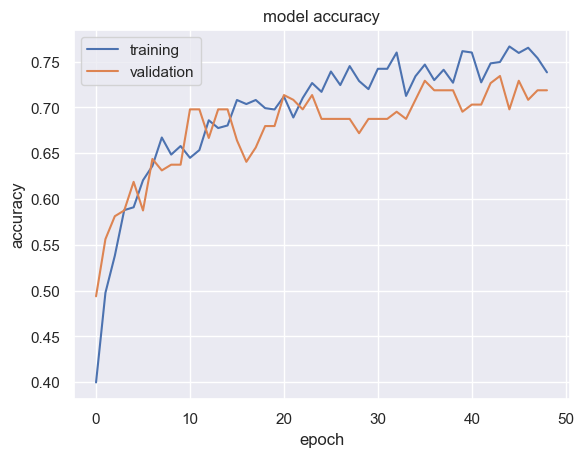

In [1559]:
                         
#cat_acc_history = []
#val_cat_history = []


for i in range(5):
    
    m = rd.randint( low = 3, high = 7)
    
    print('Loop: ',i+1)
    print('m: ', m)
    data_generator = ImageDataGenerator(rescale = 1./255, 
                                        zoom_range = 0.1, 
                                        rotation_range = 25, 
                                        width_shift_range = 0.2,
                                        validation_split  = m*0.04,
                                        height_shift_range = 0.2)

    validation_generator = ImageDataGenerator(rescale = 1./255, 
                                              validation_split = m*.04)

    DIRECTORY = "micrographs"
    CLASS_MODE = 'categorical'
    COLOR_MODE = 'rbg'
    TARGET_SIZE = (645,522)
    BATCH_SIZE = 32

    df_dir = 'micrographs'
    DATAFRAME =  new_df#ohe_main_micrographs
    XCOL =  'path'
    YCOL = ['anneal_temperature']


    df_train_it = data_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                    directory = df_dir,
                                                    x_col = XCOL,
                                                    y_col = 'anneal_temperature',
                                                    class_mode = 'categorical',
                                                    classes = temperature_classes,
                                                    suffle = True,
                                                    subset = 'training',
                                                    target_size = TARGET_SIZE,
                                                    sample_weights = t_class_weights,
                                                    batch_size = BATCH_SIZE)

    df_valid_it = validation_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                    directory = df_dir,
                                                    x_col = XCOL,
                                                    y_col = 'anneal_temperature',
                                                    class_mode = 'categorical',
                                                    classes = temperature_classes,
                                                    shuffle = True,
                                                    subset = 'validation',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = BATCH_SIZE)




    model_fit_df = model_df.fit(df_train_it,
                         steps_per_epoch = df_train_it.samples/BATCH_SIZE,
                         epochs = 5,
                         validation_data = df_valid_it,
                         validation_steps = df_valid_it.samples/BATCH_SIZE

                         )
    cat_acc_history += model_fit_df.history['categorical_accuracy']
    val_cat_history += model_fit_df.history['val_categorical_accuracy']
    
    
    
    
    
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(cat_acc_history)
ax1.plot(val_cat_history)
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

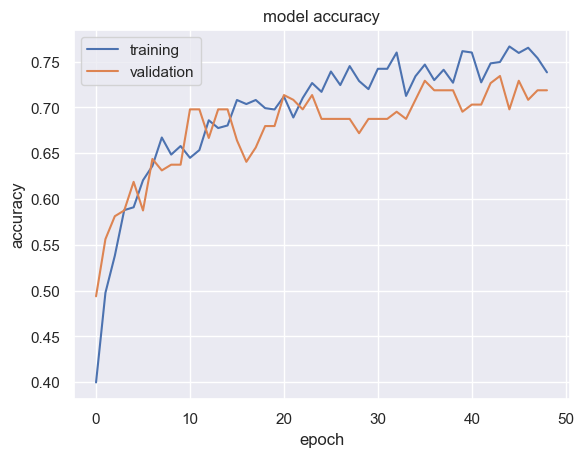

In [1566]:
#model_fit_df.history['categorical_accuracy']

#model_fit_df.history['val_categorical_accuracy']

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(cat_acc_history)
ax1.plot(val_cat_history)
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

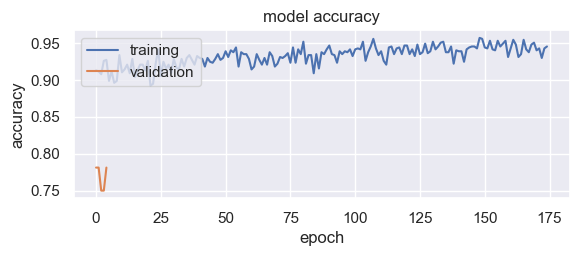

In [1520]:


fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax1.plot(cat_acc_history)
ax1.plot(model_fit_df.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

'''
ax2 = fig.add_subplot(2,1,2)
ax2.plot(model_fit_df.history['auc_37'])
ax2.plot(model_fit_df.history['val_auc_37'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['training', 'validation'], loc = 'upper left')
'''
plt.show



In [1186]:

from sklearn.metrics import classification_report

In [1519]:


test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predictions = model_df.predict(df_valid_it, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = df_valid_it.classes
class_labels = list(df_valid_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   




1/1 [==============================] - 1s 1s/step


ValueError: Number of classes, 6, does not match size of target_names, 8. Try specifying the labels parameter

In [1436]:
class_labels

['1273.15',
 '1243.15',
 'Not Annealed',
 '1023.15',
 '1173.15',
 '1373.15',
 '973.15',
 '1073.15']

In [ ]:
tt_model_df = model_builder(df_train_it)

In [1202]:
tt_model_fit_df = tt_model_df.fit(df_train_it,
                     steps_per_epoch = df_train_it.samples/BATCH_SIZE,
                     epochs = 50,
                     validation_data = df_valid_it,
                     validation_steps = df_valid_it.samples/BATCH_SIZE
                     
                     )


array([1.1215320e-06, 7.5080692e-07, 5.4082684e-14, 1.4050298e-04,
       1.4521900e-04, 3.0819073e-11, 2.3936154e-13, 2.5846060e-07,
       3.1662314e-10, 5.3814210e-07, 9.7411603e-01, 2.6279237e-10,
       9.0949343e-14, 7.2270500e-06, 1.6557843e-09, 8.9377186e-11,
       3.5331265e-08, 1.6587543e-07, 1.3043757e-09, 2.3187436e-19,
       1.4905744e-04, 8.5839096e-09, 3.6615230e-08, 2.0936090e-03,
       1.4597202e-09, 1.5867286e-03, 5.8025190e-08, 1.3913878e-09,
       4.2138592e-05, 5.2547812e-16, 2.6405969e-09, 5.9475319e-04,
       1.9703274e-10, 1.4717085e-12, 8.7623711e-04, 8.0894670e-06,
       4.0005876e-08, 4.2004933e-13, 1.2703426e-13, 1.8759007e-11,
       1.2786488e-06, 5.2473004e-12, 9.1262255e-04, 1.8863391e-02,
       3.5781892e-13, 1.3844173e-06, 2.3264828e-04, 2.3590191e-10,
       1.1620334e-06, 7.6398806e-07, 6.1860830e-13, 8.3416496e-11,
       4.4429571e-09, 3.6941630e-12, 3.2464132e-11, 5.2399784e-05,
       1.1352231e-06, 2.1884688e-08, 1.6085015e-11, 1.1033620e

In [ ]:


test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predictions = tt_model_df.predict(df_valid_it, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(df_valid_it.samples / df_valid_it.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = df_valid_it.classes
class_labels = list(df_valid_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   


# Tensorflow Keras Regression Model


In [413]:
m_a_trunc = m_a[['path','anneal_time_minutes', 'anneal_temperature']]

In [465]:
from sklearn.preprocessing import StandardScaler

In [494]:
scaler = StandardScaler()

m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] = scaler.fit_transform(m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] )


C:\Users\Owner\AppData\Local\Temp\ipykernel_22316\232795710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] = scaler.fit_transform(m_a_trunc[['anneal_time_minutes', 'anneal_temperature']] )


In [495]:
m_a_trunc

,path,anneal_time_minutes,anneal_temperature
1,micrograph2.tif,3.917963,-1.439328
3,micrograph5.tif,-0.588127,-2.039617
4,micrograph6.tif,-0.512952,0.601656
5,micrograph7.tif,-0.512952,0.601656
7,micrograph9.tif,-0.512952,0.601656
...,...,...,...
792,micrograph1716.tif,3.917963,-1.439328
795,micrograph1720.tif,0.681007,-1.439328
797,micrograph1722.tif,0.681007,0.601656
799,micrograph1726.tif,-0.588127,0.601656


# Transfer Learning:  InceptionV3 Regeression model

In [1457]:
R_X = 'path'
R_Y = [ 'anneal_time_minutes','anneal_temperature']

In [1470]:
df_train_tr = data_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                directory = df_dir,
                                                x_col = R_X,
                                                y_col = R_Y,
                                                class_mode= 'raw',
                                                color_mode = 'rgb',
                                                subset = 'training',
                                                sample_weights = t_class_weights,
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

df_valid_tr = validation_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                directory = df_dir,
                                                x_col = R_X,
                                                y_col = R_Y,
                                                class_mode = 'raw',
                                                color_mode = 'rgb',
                                                subset = 'validation',
                                                sample_weights = t_class_weights,
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

Found 495 validated image filenames.
Found 32 validated image filenames.


In [871]:
inception = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

In [872]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
    
def trans_reg_model_builder(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))
    model.add(tf.keras.layers.CenterCrop(256, 256))
    model.add(inception)
    model.add(layers.Flatten())
    
    
    model.add(layers.Dense(500, activation = 'relu'))
    
    model.add(layers.Dropout(.3))
    
    model.add(layers.Dense(2))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
                loss ='mse',
                metrics=[tf.keras.metrics.mean_squared_error]
                 )
    
    model.summary()
    return model

In [1565]:
trans_reg_model = trans_reg_model_builder(df_train_tr)


Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_72 (CenterCrop  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_182 (Flatten)       (None, 73728)             0         
                                                                 
 dense_454 (Dense)           (None, 500)               36864500  
                                                                 
 dropout_412 (Dropout)       (None, 500)               0         
                                                                 
 dense_455 (Dense)           (None, 2)                 1002      
                                                    

In [1568]:
mse_hist = mse_hist[1:]
mse_valid_hist = mse_valid_hist[1:]

In [ ]:
#mse_hist = []
#mse_valid_hist = []

for j in range(10):
    m = rd.randint( low = 1, high = 5)
    
    print('Loop: ', j+1)
    reg_data_generator = ImageDataGenerator(rescale = 1./255, 
                                        zoom_range = 0.1, 
                                        rotation_range = 25, 
                                        width_shift_range = 0.2,
                                        validation_split  = m*0.061,
                                        height_shift_range = 0.2)

    reg_validation_generator = ImageDataGenerator(rescale = 1./255, 
                                              validation_split = m*.061)

    DIRECTORY = "micrographs"
    CLASS_MODE = 'categorical'
    COLOR_MODE = 'rbg'
    TARGET_SIZE = (645,522)
    BATCH_SIZE = 32

    df_dir = 'micrographs'
    DATAFRAME =  new_df#ohe_main_micrographs
    XCOL =  'path'
    YCOL = ['anneal_temperature']

    df_train_tr = reg_data_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                    directory = df_dir,
                                                    x_col = R_X,
                                                    y_col = R_Y,
                                                    class_mode= 'raw',
                                                    color_mode = 'rgb',
                                                    subset = 'training',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = 32)

    df_valid_tr = reg_validation_generator.flow_from_dataframe(dataframe = m_a_trunc,
                                                    directory = df_dir,
                                                    x_col = R_X,
                                                    y_col = R_Y,
                                                    class_mode = 'raw',
                                                    color_mode = 'rgb',
                                                    subset = 'validation',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = 32)




    trans_reg_model_fit = trans_reg_model.fit(df_train_tr,
                         steps_per_epoch = df_train_tr.samples/BATCH_SIZE,
                         epochs = 5,
                         validation_data = df_valid_tr,
                         validation_steps = df_valid_tr.samples/BATCH_SIZE,
                         callbacks = None #[early_stop]
                         )
    
    mse_hist += trans_reg_model_fit.history['mean_squared_error']
    mse_valid_hist +=trans_reg_model_fit.history['val_mean_squared_error']
    

Loop:  1
Found 431 validated image filenames.
Found 96 validated image filenames.
Epoch 1/5
13/13 [==============================] - 44s 3s/step - loss: 0.2715 - mean_squared_error: 0.2715 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 2/5
13/13 [==============================] - 41s 3s/step - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.3385 - val_mean_squared_error: 0.3385
Epoch 3/5
13/13 [==============================] - 43s 3s/step - loss: 0.2320 - mean_squared_error: 0.2320 - val_loss: 0.3644 - val_mean_squared_error: 0.3644
Epoch 4/5
13/13 [==============================] - 43s 3s/step - loss: 0.2236 - mean_squared_error: 0.2236 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 5/5
13/13 [==============================] - 42s 3s/step - loss: 0.2938 - mean_squared_error: 0.2938 - val_loss: 0.3710 - val_mean_squared_error: 0.3710
Loop:  2
Found 399 validated image filenames.
Found 128 validated image filenames.
Epoch 1/5
12/12 [=======================

<function matplotlib.pyplot.show(close=None, block=None)>

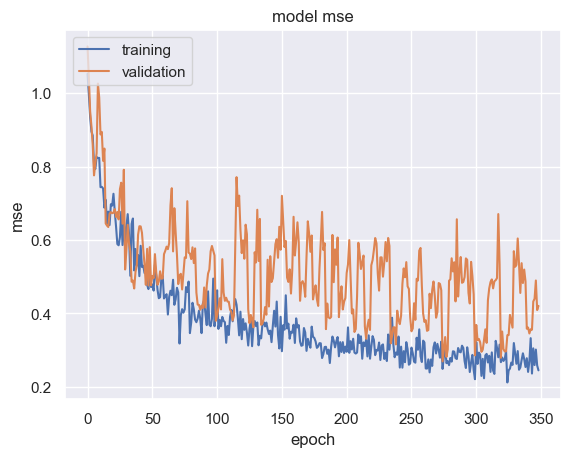

In [1582]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(mse_hist)
ax1.plot(mse_valid_hist)
ax1.set_title('model mse')
ax1.set_xlabel('epoch')
ax1.set_ylabel('mse')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

# Keras model with data augmentation in layers stratified train-test validation

I'll be switching the data augmentation to the layers for the keras model rather than using the DataImageGeneartor


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
col_select = ['micrograph_id', 'anneal_time', 'anneal_time_unit', 'anneal_temperature']

In [ ]:
to_min = ToMinutes(time_temp['anneal_time_unit'])
anneal_time_minute = to_min.transform(time_temp['anneal_time'])

In [ ]:
time_temp = m_s_pd[col_select]

In [ ]:
time_temp.insert(2, 'anneal_time_minutes', anneal_time_minute,True)

In [ ]:
time_temperature = time_temp[['micrograph_id','anneal_time_minutes','anneal_temperature']]


In [ ]:
tt_df = time_temperature.fillna('Not Annealed')

In [ ]:
tt_df['tt_start'] = tt_df['anneal_time_minutes'].astype(str) + "_" + tt_df['anneal_temperature'].astype(str)

In [ ]:
train, test = train_test_split(tt_df, test_size = 0.3, stratify = tt_df['tt_start'])

class weighting using sklearn

In [3]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train['anneal_time_minutes'].unique(),
                                     y = train['anneal_time_minutes'])

In [ ]:
cw_dict = dict(zip(train['anneal_time_minutes'].unique(),class_weights))

New Model Constructions


preprocessing layers \
2D cropping layer \
rescaling (perhaps keep this in dataimagegenerator )


data augmentation\
random crop\
random flip\
random trnslation\
random rotation\
random zoon\
random contrast\

In [ ]:
def model_builder(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))

    
    model.add(layers.Cropping2D(
              cropping=((0, 40), (0, 0))
                ))
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    
    model.add(layers.RandomZoom(.4,.2)
    model.add(layers.RandomContrast(.2))          
    model.add(layers.RandomCrop(256,256))
    
    
    model.add(inception)
    

    
    model.add(layers.Flatten())

    model.add(layers.Dense(500, activation = 'sigmoid'))
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(8, activation = 'softmax'))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = tf.keras.metrics.CategoricalAccuracy() #,tf.keras.metrics.AUC()]
                 )
    
    model.summary()
    return model
    
    

In [ ]:

for i in range(5):
    
    #put the train/validation split here
    
    m = rd.randint( low = 3, high = 7)
    
    print('Loop: ',i+1)
    print('m: ', m)
    data_generator = ImageDataGenerator(rescale = 1./255)

    validation_generator = ImageDataGenerator(rescale = 1./255)

    DIRECTORY = "micrographs"
    CLASS_MODE = 'categorical'
    COLOR_MODE = 'rbg'
    TARGET_SIZE = (645,522)
    BATCH_SIZE = 32

    df_dir = 'micrographs'
    DATAFRAME =  new_df#ohe_main_micrographs
    XCOL =  'path'
    YCOL = ['anneal_temperature']


    df_train_it = data_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                    directory = df_dir,
                                                    x_col = XCOL,
                                                    y_col = 'anneal_temperature',
                                                    class_mode = 'categorical',
                                                    classes = temperature_classes,
                                                    suffle = True,
                                                    subset = 'training',
                                                    target_size = TARGET_SIZE,
                                                    sample_weights = t_class_weights,
                                                    batch_size = BATCH_SIZE)

    df_valid_it = validation_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                    directory = df_dir,
                                                    x_col = XCOL,
                                                    y_col = 'anneal_temperature',
                                                    class_mode = 'categorical',
                                                    classes = temperature_classes,
                                                    shuffle = True,
                                                    subset = 'validation',
                                                    sample_weights = t_class_weights,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = BATCH_SIZE)




    model_fit_df = model_df.fit(df_train_it,
                         steps_per_epoch = df_train_it.samples/BATCH_SIZE,
                         epochs = 5,
                         validation_data = df_valid_it,
                         validation_steps = df_valid_it.samples/BATCH_SIZE

                         )
    cat_acc_history += model_fit_df.history['categorical_accuracy']
    val_cat_history += model_fit_df.history['val_categorical_accuracy']
    
    
    
    
    
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(cat_acc_history)
ax1.plot(val_cat_history)
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show